# Linear Layer (forward)

Maps each input vector to a new space via an affine transformation.

## 🧮 Formula

Let  

$$
X \in \mathbb{R}^{N \times D_{in}}
$$
*(input batch)*  

$$
W \in \mathbb{R}^{D_{in} \times D_{out}}
$$
*(weight matrix)*  

$$
b \in \mathbb{R}^{D_{out}}
$$
*(bias vector)*  

Then the forward pass is:

$$
Y = XW + b
$$

where \( b \) is broadcasted along the batch dimension.

Output shape:

$$
Y \in \mathbb{R}^{N \times D_{out}}
$$



In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Linear:

    def __init__(self, in_features: int, out_features: int, bias: bool = True):

        self.W = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros(out_features) if bias else None


    def forward(self, X: np.ndarray) -> np.ndarray:

        out = X @ self.W  # (N, D_in) @ (D_in, D_out) -> (N, D_out)
        if self.b is not None:

            # broadcast over batch dimension
            out = out + self.b
        return out

# Pytorch implementation

In [8]:
import torch
import torch.nn as nn

class LinearTorch(nn.Module):

    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.W = nn.Parameter(torch.randn(in_features, out_features) * 0.01)
        self.b = nn.Parameter(torch.zeros(out_features)) if bias else None

    def forward(self, X):  # X: (N, D_in)
        out = X @ self.W   # (N, D_out)
        if self.b is not None:
            out = out + self.b
        return out

# Backrop


**Goal:** Derive gradients of loss \( L \) w.r.t. weights, bias, and input.

### Formula
Given  
$$
Y = XW + b
$$  
and upstream gradient $$  \frac{\partial L}{\partial Y} = dY  $$

the gradients are:
$$
dW = X^T dY
$$
$$
db = \text{sum}(dY, \text{axis}=0)
$$
$$
dX = dY W^T
$$

In [9]:
class Linear:
    def __init__(self, in_features, out_features):
        self.W = np.random.randn(in_features, out_features) * 0.01
        self.b = np.zeros(out_features)

    def forward(self, X):
        self.X = X
        return X @ self.W + self.b

    def backward(self, dY):
        dW = self.X.T @ dY
        db = np.sum(dY, axis=0)
        dX = dY @ self.W.T
        return dX, dW, db

In [10]:
def relu(x): return np.maximum(0, x)

class TwoLayerMLP:
    def __init__(self, D_in, H, D_out):
        self.W1 = np.random.randn(D_in, H) * 0.01
        self.b1 = np.zeros(H)
        self.W2 = np.random.randn(H, D_out) * 0.01
        self.b2 = np.zeros(D_out)

    def forward(self, X):
        self.X = X
        self.h = relu(X @ self.W1 + self.b1)
        return self.h @ self.W2 + self.b2

# 2-Layer MLP (Forward, ReLU)

For one hidden layer:
$$
h = \text{ReLU}(XW_1 + b_1)
$$
$$
Y = hW_2 + b_2
$$

In [11]:
def relu(x): return np.maximum(0, x)

class TwoLayerMLP:
    def __init__(self, D_in, H, D_out):
        self.W1 = np.random.randn(D_in, H) * 0.01
        self.b1 = np.zeros(H)
        self.W2 = np.random.randn(H, D_out) * 0.01
        self.b2 = np.zeros(D_out)

    def forward(self, X):
        self.X = X
        self.h = relu(X @ self.W1 + self.b1)
        return self.h @ self.W2 + self.b2

## 🔁 2-Layer MLP (Backward, ReLU)

### Gradients

$$
dW_2 = h^T dY, \quad db_2 = \sum dY
$$

$$
dh = dY W_2^T
$$

$$
dh_{\text{ReLU}} = dh \cdot (h > 0)
$$

$$
dW_1 = X^T dh_{\text{ReLU}}, \quad db_1 = \sum dh_{\text{ReLU}}
$$


In [12]:
def relu_grad(x): return (x > 0).astype(float)

class TwoLayerMLP(TwoLayerMLP):

    def backward(self, dY):

        dW2 = self.h.T @ dY
        db2 = np.sum(dY, axis=0)

        dh = dY @ self.W2.T
        dh_relu = dh * relu_grad(self.h)

        dW1 = self.X.T @ dh_relu
        db1 = np.sum(dh_relu, axis=0)

        dX = dh_relu @ self.W1.T

        return dX, (dW1, db1, dW2, db2)

## ☔ Day 19 — Dropout (Forward + Backward)

### Formula
Forward (train):
$$
\text{mask} = (U > p), \quad U \sim \text{Uniform}(0,1)
$$
$$
Y = \frac{X \cdot \text{mask}}{1-p}
$$
Backward:
$$
dX = \frac{dY \cdot \text{mask}}{1-p}
$$

In [13]:
class Dropout:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, X, train=True):

        if not train:
            return X

        self.mask = (np.random.rand(*X.shape) > self.p).astype(float)
        return X * self.mask / (1 - self.p)

    def backward(self, dY):
        return dY * self.mask / (1 - self.p)

## 🧠 Intuition
Dropout is a **regularization technique** used to prevent overfitting in neural networks.  
During training, it **randomly "drops" (sets to zero)** a fraction \( p \) of neuron activations in a layer on each forward pass.  
This forces the network to **not rely too heavily on specific neurons** and to learn redundant, robust representations.

Mathematically (for a layer input \( X \)):
$$
\text{mask} \sim \text{Bernoulli}(1 - p)
$$
$$
Y = \frac{X \cdot \text{mask}}{1 - p}
$$
At inference time, dropout is turned **off** and the activations are used as-is (already scaled by \(1-p\)).

---

## ⚙️ Core Idea
Think of dropout as **training an ensemble of many smaller subnetworks** that share weights.  
Each training batch sees a slightly different architecture (due to random drops),  
and their combined effect behaves like model averaging — reducing variance and overfitting.

---

## 🚀 Practical Benefits
- **Improves generalization** by discouraging co-adaptation of neurons.  
- **Acts like model ensembling** but with almost zero extra computation.  
- **Simplifies training dynamics** when used in dense layers of smaller to medium-sized networks.

---

## ⚠️ Caveats / Expert Notes
- **Less effective in very large models** (e.g., modern transformers) — those already use  
  techniques like **LayerNorm**, **residual connections**, and **weight decay** for regularization.  
  Dropout can even hurt convergence there.
- **BatchNorm + Dropout** can interact poorly: BatchNorm’s moving averages expect stable activation statistics,  
  while dropout injects random noise — so most modern architectures (e.g., ResNet, ViT) avoid combining them.
- **Don’t use at inference** — ensure `model.eval()` or `train=False` is set.
- In large-scale pretraining (LLMs, ViTs), dropout rates are typically **very low (0.1–0.2)** or disabled entirely.

---

In [ ]:
# ---------- Layers ----------

class Linear:
    def __init__(self, in_f, out_f):
        self.W = np.random.randn(in_f, out_f) * 0.01
        self.b = np.zeros(out_f)
    def forward(self, X):
        self.X = X
        return X @ self.W + self.b
    def backward(self, dY, lr=0.1):
        dW = self.X.T @ dY
        db = np.sum(dY, axis=0)
        dX = dY @ self.W.T
        self.W -= lr * dW
        self.b -= lr * db
        return dX

In [14]:
# ---------- Utilities ----------

def relu(x): return np.maximum(0, x)


def relu_grad(x): return (x > 0).astype(float)


def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2), (2 * (y_pred - y_true)) / y_true.shape[0]

In [16]:
# ---------- Simple MLP ----------

class MLP:
    def __init__(self, D_in, H, D_out, dropout_p=0.0):
        self.fc1 = Linear(D_in, H)
        self.dropout = Dropout(dropout_p)
        self.fc2 = Linear(H, D_out)

    def forward(self, X, train=True):
        self.h = relu(self.fc1.forward(X))
        self.h = self.dropout.forward(self.h, train)
        return self.fc2.forward(self.h)

    def backward(self, dY, lr=0.1):
        dY = self.fc2.backward(dY, lr)
        dY = dY * relu_grad(self.h)
        dY = self.dropout.backward(dY)
        self.fc1.backward(dY, lr)

In [17]:
# ---------- Training loop ----------

def train_model(dropout_p):
    np.random.seed(0)
    X = np.random.randn(200, 10)
    true_W = np.random.randn(10, 1)
    y = X @ true_W + 0.5 * np.random.randn(200, 1)

    model = MLP(D_in=10, H=32, D_out=1, dropout_p=dropout_p)
    losses = []
    for epoch in range(100):
        y_pred = model.forward(X, train=True)
        loss, dY = mse_loss(y_pred, y)
        losses.append(loss)
        model.backward(dY)
    return losses

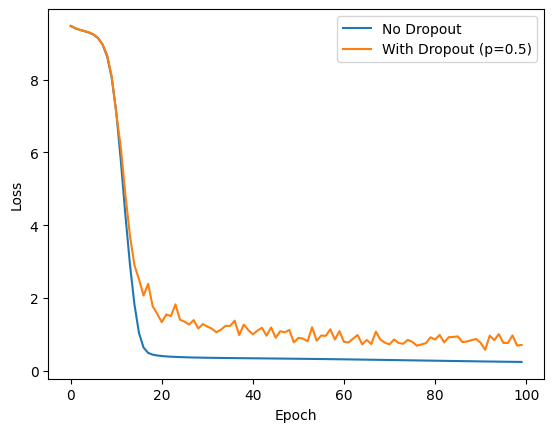

In [18]:
loss_no_dropout = train_model(dropout_p=0.0)
loss_with_dropout = train_model(dropout_p=0.5)


plt.plot(loss_no_dropout, label='No Dropout')
plt.plot(loss_with_dropout, label='With Dropout (p=0.5)')
plt.legend(); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.show()